# Predizione del prezzo delle auto

**Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena


**Matteucci Andrea**  <br>
0000874761   <br> 
**`andrea.matteucci5@studio.unibo.it`**

Citazioni:
* Another Dataset on used Fiat 500 https://www.kaggle.com/paolocons/another-fiat-500-dataset-1538-rowsm

## Descrizione del Problema e Comprensione dei Dati
In questo progetto si vuole realizzare un modello in grado di predire il prezzo di auto Fiat usate in base ad alcune caratteristiche specifiche come modello, km percorsi, numero di kW del motore e numero di precedenti proprietari.

## Importazione delle librerie

Come prima cosa andiamo ad importare le librerie che utilizzeremo:

- numpy (operazioni su vettori e matrici N-dimensionali)
- pandas (caricamento e la gestione dei dati tabellare)
- matplotlib (creazione di diverse tipologie di grafici)
- seaborn (per disegnare grafici statistici interessanti e informativ)

Consentiamo poi l'inserimento dei grafici direttamente nel notebook con *%matplotlib inline*.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import seaborn as sb

%matplotlib inline

## Caricamento del set di dati
Si recupera dalla Reposition GitHub il file del dataset


In [41]:
import os.path
if not os.path.exists("automobile_dot_it_used_fiat_500_in_Italy_dataset_filtered.csv"):
    from urllib.request import urlretrieve
    urlretrieve("https://raw.githubusercontent.com/AndyMatte99/progetto_data_intensive/main/automobile_dot_it_used_fiat_500_in_Italy_dataset_filtered.csv", "automobile_dot_it_used_fiat_500_in_Italy_dataset_filtered.csv")
    
    
    

In [4]:
data = pd.read_csv("automobile_dot_it_used_fiat_500_in_Italy_dataset_filtered.csv", sep=",")

In [5]:
data.head()

,model,engine_power,age_in_days,km,previous_owners,lat,lon,price
0,lounge,51,882,25000,1,44.907242,8.611560,8900
1,pop,51,1186,32500,1,45.666359,12.241890,8800
2,sport,74,4658,142228,1,45.503300,11.417840,4200
3,lounge,51,2739,160000,1,40.633171,17.634609,6000
4,pop,73,3074,106880,1,41.903221,12.495650,5700


## Preprocessing del dataset

Iniziamo cambiando nome alle colonne per una migliore comprensione del set di dati.

In [6]:
data.columns = "Modello Potenza_Motore Giorni_Di_Vita Kilometri Vecchi_Propietari Latitudine Longitudine Prezzo".split()

data

,Modello,Potenza_Motore,Giorni_Di_Vita,Kilometri,Vecchi_Propietari,Latitudine,Longitudine,Prezzo
0,lounge,51,882,25000,1,44.907242,8.611560,8900
1,pop,51,1186,32500,1,45.666359,12.241890,8800
2,sport,74,4658,142228,1,45.503300,11.417840,4200
3,lounge,51,2739,160000,1,40.633171,17.634609,6000
4,pop,73,3074,106880,1,41.903221,12.495650,5700
...,...,...,...,...,...,...,...,...
1533,sport,51,3712,115280,1,45.069679,7.704920,5200
1534,lounge,74,3835,112000,1,45.845692,8.666870,4600
1535,pop,51,2223,60457,1,45.481541,9.413480,7500
1536,lounge,51,2557,80750,1,45.000702,7.682270,5990


Notiamo che nel dataframe non è presente una colonna utilizzabile come indice, perciò vado a crearne una che identifichi univocamente ogni record


In [7]:
data.insert(0, 'Id', range(0, len(data)))
data.set_index("Id", inplace=True)
data.head(5)

,Modello,Potenza_Motore,Giorni_Di_Vita,Kilometri,Vecchi_Propietari,Latitudine,Longitudine,Prezzo
Id,,,,,,,,
0,lounge,51,882,25000,1,44.907242,8.611560,8900
1,pop,51,1186,32500,1,45.666359,12.241890,8800
2,sport,74,4658,142228,1,45.503300,11.417840,4200
3,lounge,51,2739,160000,1,40.633171,17.634609,6000
4,pop,73,3074,106880,1,41.903221,12.495650,5700


Proseguiamo controllando la presenza di valori NaN.

In [8]:
data.isna().sum()

Modello              0
Potenza_Motore       0
Giorni_Di_Vita       0
Kilometri            0
Vecchi_Propietari    0
Latitudine           0
Longitudine          0
Prezzo               0
dtype: int64

Non vi sono oggetti NaN, quindi possiamo analizzare la struttura del dataset.

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1538 entries, 0 to 1537
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Modello            1538 non-null   object 
 1   Potenza_Motore     1538 non-null   int64  
 2   Giorni_Di_Vita     1538 non-null   int64  
 3   Kilometri          1538 non-null   int64  
 4   Vecchi_Propietari  1538 non-null   int64  
 5   Latitudine         1538 non-null   float64
 6   Longitudine        1538 non-null   float64
 7   Prezzo             1538 non-null   int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 108.1+ KB


Notiamo che abbiamo un tipo *object* per cui eseguiamo una one hot encoding, eliminando la colonna *model* e aggiungendo n colonne dove n sono i modelli presenti nel nostro dataset.

In [10]:
categorical = ['Modello']

data = pd.get_dummies(data, columns=categorical, prefix=categorical)

Ora possiamo osservare come per ogni macchina (riga) troviamo 1 nel modello corrispondente e 0 negli altri.

In [11]:
data.head()

,Potenza_Motore,Giorni_Di_Vita,Kilometri,Vecchi_Propietari,Latitudine,Longitudine,Prezzo,Modello_lounge,Modello_pop,Modello_sport
Id,,,,,,,,,,
0,51,882,25000,1,44.907242,8.611560,8900,1,0,0
1,51,1186,32500,1,45.666359,12.241890,8800,0,1,0
2,74,4658,142228,1,45.503300,11.417840,4200,0,0,1
3,51,2739,160000,1,40.633171,17.634609,6000,1,0,0
4,73,3074,106880,1,41.903221,12.495650,5700,0,1,0


## Comprensione delle feature

Per capire meglio cosa rappresentano, quindi, le colonne della tabella andiamo ad analizzarle una ad una:

- **Id**: id assegnato da noi
- **Potenza_Motore**: potenza del motore in KW
- **Giorni_Di_Vita**: giorni di vita della macchina
- **Kilometri**: kilometri percorsi
- **Vecchi_Propietari**: numero di proprietari precedenti
- **Latitudine**: latitudine del venditore
- **Longitudine**: longitudine del venditore
- **Modello_lounge**: 1- si tratta di un modello lounge 0- NON si tratta di un modello lounge
- **Modello_pop**: 1- si tratta di un modello lounge 0- NON si tratta di un modello lounge
- **Modello_sport**: 1- si tratta di un modello lounge 0- NON si tratta di un modello lounge

Variabile da predire:
- **Prezzo**: prezzo di vendita della macchina

## Esplorazione delle singole feature

Ora che il set di dati è caricato e modificato correttamente possiamo procedere con l'esplorazione delle singole feature.
Per cominciare utilizziamo il comando *describe* che fornisce, per ogni colonna, informazioni come il conteggio degli elementi, i valori minimo e massimo, la media e la deviazione standard, i percentili di distribuzione.

In [12]:
data.describe()

,Potenza_Motore,Giorni_Di_Vita,Kilometri,Vecchi_Propietari,Latitudine,Longitudine,Prezzo,Modello_lounge,Modello_pop,Modello_sport
count,1538.000000,1538.000000,1538.000000,1538.000000,1538.000000,1538.000000,1538.000000,1538.000000,1538.000000,1538.000000
mean,51.904421,1650.980494,53396.011704,1.123537,43.541361,11.563428,8576.003901,0.711313,0.232770,0.055917
std,3.988023,1289.522278,40046.830723,0.416423,2.133518,2.328190,1939.958641,0.453299,0.422734,0.229836
min,51.000000,366.000000,1232.000000,1.000000,36.855839,7.245400,2500.000000,0.000000,0.000000,0.000000
25%,51.000000,670.000000,20006.250000,1.000000,41.802990,9.505090,7122.500000,0.000000,0.000000,0.000000
50%,51.000000,1035.000000,39031.000000,1.000000,44.394096,11.869260,9000.000000,1.000000,0.000000,0.000000
75%,51.000000,2616.000000,79667.750000,1.000000,45.467960,12.769040,10000.000000,1.000000,0.000000,0.000000
max,77.000000,4658.000000,235000.000000,4.000000,46.795612,18.365520,11100.000000,1.000000,1.000000,1.000000


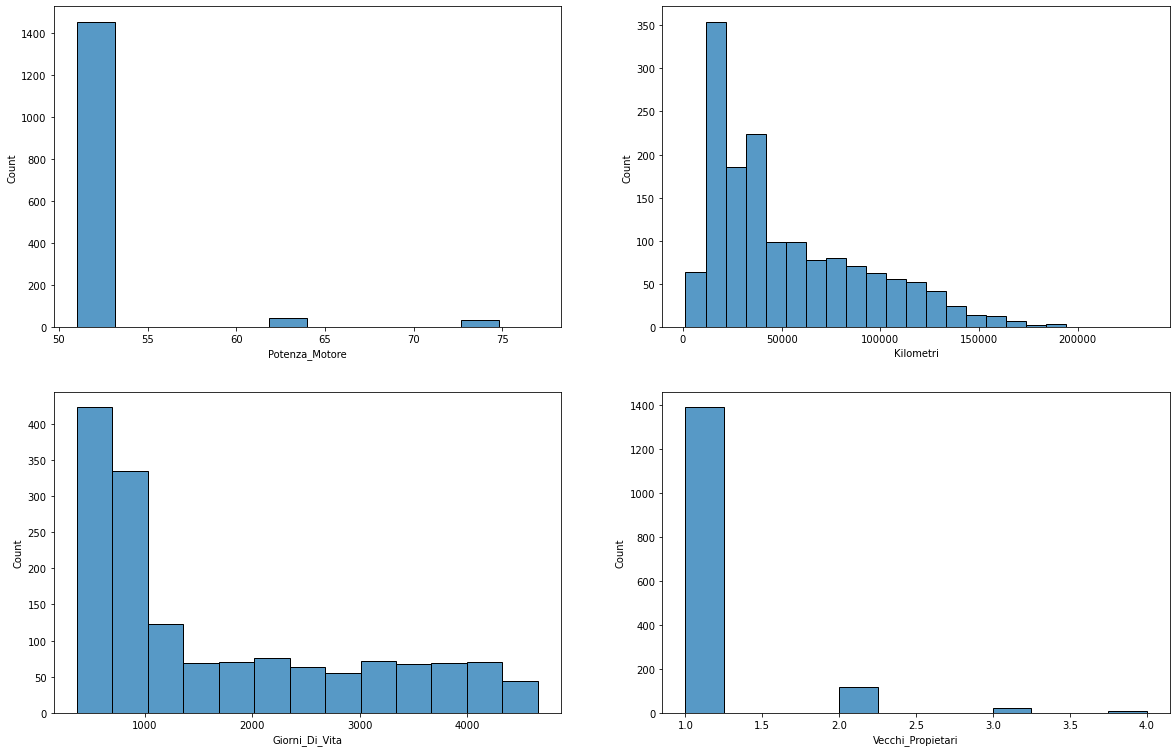

In [13]:
plt.figure(figsize=(20,13))

plt.subplot(2,2,1)
sb.histplot(x="Potenza_Motore", data=data);

plt.subplot(2,2,2)
sb.histplot(x="Kilometri", data=data);

plt.subplot(2,2,3)
sb.histplot(x="Giorni_Di_Vita", data=data);

plt.subplot(2,2,4)
sb.histplot(x="Vecchi_Propietari", data=data);

Da questi istogrammi deduciamo che La maggior parte dei veicoli:
* Hanno una potenza di 50KW
* Hanno un kilometraggio compreso tra 0 e 50000km
* Hanno meno di 1000 giorni di vita
* La maggior parte delle auto ha avuto un solo proprietario

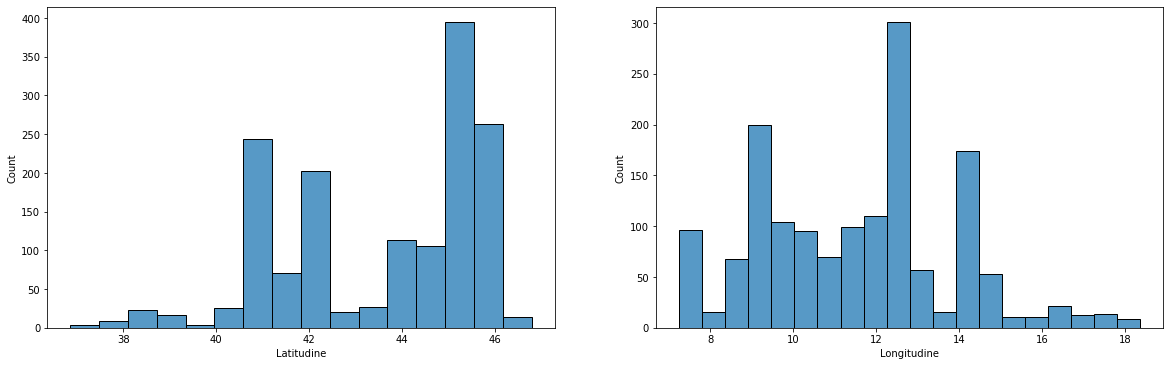

In [14]:
plt.figure(figsize=(20,13))

plt.subplot(2,2,1)
sb.histplot(x="Latitudine", data=data);

plt.subplot(2,2,2)
sb.histplot(x="Longitudine", data=data);

Da questi due isogrammi relativi a latitudine e longitudine capiamo che:
* La maggior parte delle auto appartiene ad un venditore che si trova ad una latitudine di circa 45 (capiremo successivamente che una latitudine superiore a 42 indica che ci si trova al Nord)
* La maggior parte delle auto appartiene ad un venditore che si trova ad una longitudine di circa 13

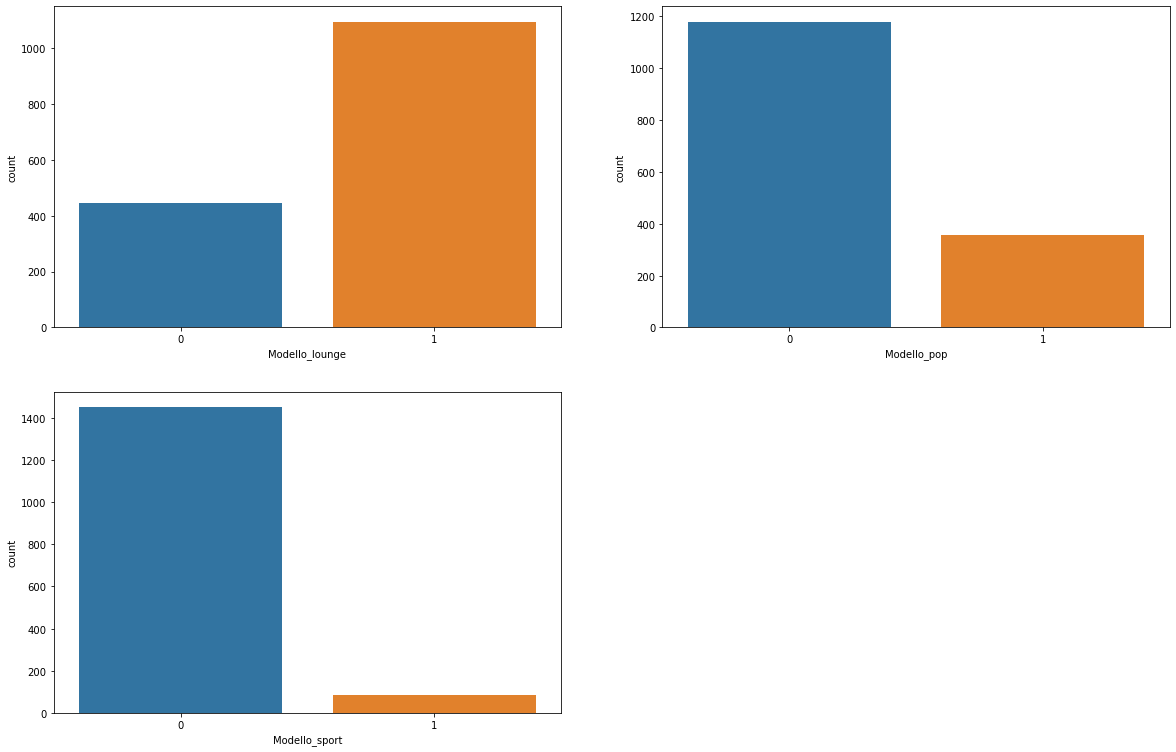

In [15]:
plt.figure(figsize=(20,13))

plt.subplot(2,2,1)
sb.countplot(x="Modello_lounge", data=data);

plt.subplot(2,2,2)
sb.countplot(x="Modello_pop", data=data);

plt.subplot(2,2,3)
sb.countplot(x="Modello_sport", data=data);

Vediamo ora tre istogrammi relativi ai tre diversi modelli delle auto. Quello che si evince è:
* Il modello lounge è quello maggiormente posseduto dai venditori
* Il modello sport è quello meno posseduto dai venditori

## Esplorazione delle relazioni tra le feature

Procediamo ora con l'analisi delle possibili relazioni tra le diverse feature.

In [16]:
data.corr(method='pearson')

,Potenza_Motore,Giorni_Di_Vita,Kilometri,Vecchi_Propietari,Latitudine,Longitudine,Prezzo,Modello_lounge,Modello_pop,Modello_sport
Potenza_Motore,1.000000,0.319190,0.285495,-0.005030,0.005721,-0.005032,-0.277235,-0.133321,0.024783,0.217362
Giorni_Di_Vita,0.319190,1.000000,0.833890,0.075775,0.062982,-0.042667,-0.893328,-0.259863,0.108327,0.313276
Kilometri,0.285495,0.833890,1.000000,0.097539,0.035519,0.004839,-0.859373,-0.255746,0.109024,0.303874
Vecchi_Propietari,-0.005030,0.075775,0.097539,1.000000,0.001697,-0.026836,-0.076274,-0.024643,-0.019316,0.084129
Latitudine,0.005721,0.062982,0.035519,0.001697,1.000000,-0.766646,-0.011733,-0.042641,0.029706,0.029463
Longitudine,-0.005032,-0.042667,0.004839,-0.026836,-0.766646,1.000000,-0.003541,0.010208,-0.003740,-0.013253
Prezzo,-0.277235,-0.893328,-0.859373,-0.076274,-0.011733,-0.003541,1.000000,0.302299,-0.167190,-0.288706
Modello_lounge,-0.133321,-0.259863,-0.255746,-0.024643,-0.042641,0.010208,0.302299,1.000000,-0.864605,-0.382017
Modello_pop,0.024783,0.108327,0.109024,-0.019316,0.029706,-0.003740,-0.167190,-0.864605,1.000000,-0.134050
Modello_sport,0.217362,0.313276,0.303874,0.084129,0.029463,-0.013253,-0.288706,-0.382017,-0.134050,1.000000


Proviamo ora a cercare di capire dove la differenza di latitudine, riferita alla posizione dei venditori, (distinguendola quindi tra Nord e Sud) ci mostra risultati ed informazioni interessanti.




Stabiliamo le latitudine minima e massima

In [17]:
print(data["Latitudine"].max(), data["Latitudine"].min())

46.79561233520508 36.855838775634766


Mostriamo poi gli intervalli delle latitudini in modo da poter capire quali confini dare a Nord e Sud

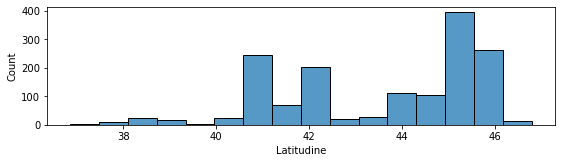

In [18]:
plt.figure(figsize=(20,10))

plt.subplot(4,2,1)
sb.histplot(x="Latitudine", data=data);

La latitudine di Roma corrisponde a 42, perciò sara esattamente la metà con cui stabilire poi nord e sud

In [19]:
nord = data["Latitudine"] > 42

In [20]:
dati_nord = data[data["Latitudine"] > 42]
dati_sud = data[data["Latitudine"] <= 42]

### Prezzo - kilometri (nord e sud)

Osserviamo l'andamento del prezzo tra nord e sud

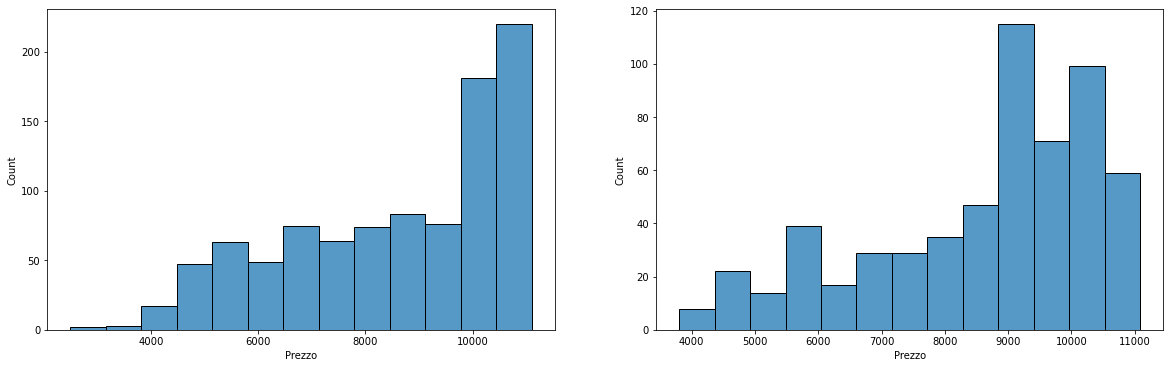

In [21]:
plt.figure(figsize=(20,13))

plt.subplot(2,2,1)
sb.histplot(x="Prezzo", data=dati_nord);

plt.subplot(2,2,2)
sb.histplot(x="Prezzo", data=dati_sud);

Notiamo che i prezzi appartengono ad un numero totale di macchine molto simile tra nord e sud. Andiamo ora a vedere la relazione tra prezzo e kilometri.

### Prezzo - kilometri (nord e sud)

Osserviamo la differenza di relazione tra prezzo e giorni di vita nei veicoli appartenenti a propietari del Nord ed appartenti a propietari del Sud

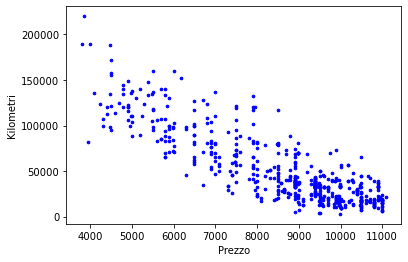

In [22]:
dati_sud.plot.scatter("Prezzo", "Kilometri", s=7, c="blue");

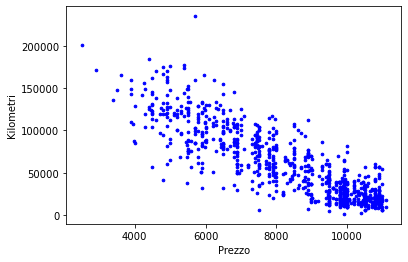

In [23]:
dati_nord.plot.scatter("Prezzo", "Kilometri", s=7, c="blue");

In [24]:
print("nord:", dati_nord["Prezzo"].sum() / dati_nord["Kilometri"].sum(), ", sud:", dati_sud["Prezzo"].sum() / dati_sud["Kilometri"].sum())




nord: 0.15471044076890908 , sud: 0.1711916218979022


Notiamo che, ad esempio, nelle grandezze prezzo e giorni_di_vita non il rapporto tra le curve dei due grafici e tra le due medie rimane molto simile. Andiamo ora però ad analizzare il rapporto tra prezzo e kilometri nei due intervalli di latitudine.

### Prezzo - giorni di vita (nord e sud)



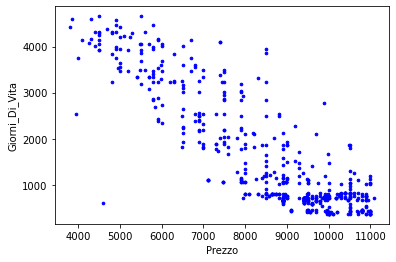

In [25]:
dati_sud.plot.scatter("Prezzo", "Giorni_Di_Vita", s=7, c="blue");

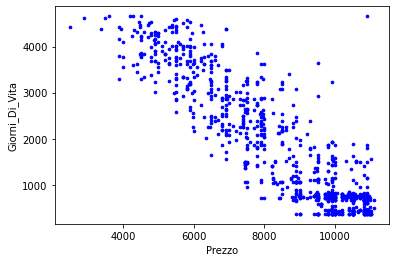

In [26]:
dati_nord.plot.scatter("Prezzo", "Giorni_Di_Vita", s=7, c="blue");

In [27]:
print("nord:", dati_nord["Prezzo"].sum() / dati_nord["Giorni_Di_Vita"].sum(), ", sud:", dati_sud["Prezzo"].sum() / dati_sud["Giorni_Di_Vita"].sum())



nord: 4.914040848294976 , sud: 5.723815339410149


Qui notiamo come, nonostante le curve rimangano molto simili, abbiamo una distanza notevole tra i due valori delle medie.

## Analisi dei modelli

In [28]:
X = data.drop(columns=['Prezzo'])
y = data["Prezzo"]

X_train,X_val,y_train,y_val = train_test_split(X, y, train_size=0.7)

### Calcoli delle regressioni

In [29]:
#Linear Regression
lrm = LinearRegression(normalize=True)
lrm.fit(X_train, y_train)
y_pred = lrm.predict(X_val)



#Polynomial Regression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
prm = Pipeline([
                ("poly",
                 PolynomialFeatures(degree=2, include_bias=False)),
                ("linreg",LinearRegression(normalize=True))
])
prm.fit(X_train, y_train)
y_pred = prm.predict(X_val)



#Polynomial regression Regression con Grid Search
from sklearn.model_selection import GridSearchCV

pipe = Pipeline(steps=[
    ('poly', PolynomialFeatures(include_bias=False)),
    ('model', LinearRegression(normalize=True)),
])

search = GridSearchCV(
    estimator=pipe,
    param_grid={'poly__degree': list(range(1,10))},
    scoring='r2',
    cv=5,
)

search.fit(X_train, y_train)



#Ridge regression
from sklearn.linear_model import Ridge
model = Ridge()
parameters = {'alpha': range(1,50)}
Ridge_reg= GridSearchCV(model, parameters, scoring='r2',cv=5)
Ridge_reg.fit(X_train, y_train)



#Lasso regression
from sklearn.linear_model import LassoCV
reg = LassoCV(cv=5, random_state=0, normalize=True).fit(X_train, y_train)

### Stampa dei risultati

In [30]:
print('\033[1m' +"Linear Regression" + '\033[0m')
print("Errore quadratico medio: " + str(np.mean((y_pred - y_val)**2)))
print("Errore relativo: "  + str(np.mean(np.abs(y_pred-y_val)/y_val)*100) + " %")
print("Indice R sui dati di addestramento: " + str(lrm.score(X_train, y_train)))
print("Indice R sui dati di validazione: " + str(lrm.score(X_val, y_val)))
print("\n")
print("---------------------------------------------------------------------------")
print("\n")
print('\033[1m' + "Polynomial Regression" + '\033[0m');
print("Errore quadratico medio: " + str(np.mean((y_pred - y_val)**2)))
print("Errore relativo: "  + str(np.mean(np.abs(y_pred-y_val)/y_val)*100) + " %")
print("Indice R quadro sui dati di addestramento: " + str(prm.score(X_train, y_train)))
print("Indice R quadro sui dati di validazione: " + str(prm.score(X_val, y_val)))
print("\n")
print('\033[1m'+ "Polynomial Regression con Grid Search" + '\033[0m');
print("R quadro: " + str(search.score(X_val,y_val)))
print("Grado del polinomio migliore: " + str(search.best_params_["poly__degree"]))
print("\n")
print("---------------------------------------------------------------------------")
print("\n")
print('\033[1m' + "Ridge Regression" + '\033[0m' );
print("Alpha migliore: " + str(Ridge_reg.best_params_['alpha']))
print("R quadro: " + str(Ridge_reg.score(X_val, y_val)))
print("\n")
print("---------------------------------------------------------------------------")
print("\n")
print('\033[1m' + "Lasso Regression" + '\033[0m' )
print("R quadro: " + str(reg.score(X_val, y_val)))
print("Alpha migliore: " + str(reg.alpha_))
print("Numero iterazioni: " + str(reg.n_iter_))



Linear Regression
Errore quadratico medio: 613123.8110808099
Errore relativo: 7.84831210757761 %
Indice R sui dati di addestramento: 0.8448596563952965
Indice R sui dati di validazione: 0.8474278072031867


---------------------------------------------------------------------------


Polynomial Regression
Errore quadratico medio: 613123.8110808099
Errore relativo: 7.84831210757761 %
Indice R quadro sui dati di addestramento: 0.8589794984315311
Indice R quadro sui dati di validazione: 0.8356120619270119


Polynomial Regression con Grid Search
R quadro: 0.8356120619270119
Grado del polinomio migliore: 2


---------------------------------------------------------------------------


Ridge Regression
Alpha migliore: 49
R quadro: 0.8476474447254094


---------------------------------------------------------------------------


Lasso Regression
R quadro: 0.8497284593450879
Alpha migliore: 0.8007855254802152
Numero iterazioni: 24


Da questi valori stampati possiamo osservare che Linear Regression e Polynomial Regression hanno un errore relativo molto simile. Inoltre vedendo un indice R quadro rispettivamente di circa 0.84 per l'addestramento e di 0.86 per la validazione possiamo dire di avere una discreta precisione nei dati.

Proviamo ora a fare successivamente a migliorare il nostro indice R con Ridge Regression e Lasso Regression

Anche qui notiamo un valore di R quadro che ci indica che è presente una discreta precisione nei dati, anche se comunque non abbiamo acuto un significativo miglioramento.

### Coefficienti angolari

In [31]:
print('\033[1m' +"Linear Regression" + '\033[0m')
for c,p in zip(X.columns, lrm.coef_):
    print(c,p)
print("\n")
print("---------------------------------------------------------------------------")
print("\n")
print('\033[1m' + "Polynomial Regression" + '\033[0m');
for c,p in zip(X.columns, prm.named_steps['linreg'].coef_):
    print(c,p)
print("\n")
print('\033[1m'+ "Polynomial Regression con Grid Search" + '\033[0m');
for c,p in zip(X.columns, search.best_estimator_.named_steps['model'].coef_):
    print(c,p)
print("\n")
print("---------------------------------------------------------------------------")
print("\n")
print('\033[1m' + "Ridge Regression" + '\033[0m' );
for c,p in zip(X.columns, Ridge_reg.best_estimator_.coef_):
    print(c,p)
print("\n")
print("---------------------------------------------------------------------------")
print("\n")
print('\033[1m' + "Lasso Regression" + '\033[0m' )
for c,p in zip(X.columns, reg.coef_):
    print(c,p)

Linear Regression
Potenza_Motore -0.4077122434482652
Giorni_Di_Vita -0.8686862529581116
Kilometri -0.018386288441295126
Vecchi_Propietari 29.83714669575452
Latitudine 65.1023989313507
Longitudine 28.616267437401508
Modello_lounge 1.3158154141684382e+16
Modello_pop 1.3158154141684084e+16
Modello_sport 1.3158154141684388e+16


---------------------------------------------------------------------------


Polynomial Regression
Potenza_Motore -4086727840734.986
Giorni_Di_Vita -0.20239377549219859
Kilometri -0.04320348269113718
Vecchi_Propietari -1217.8518992040215
Latitudine -2199.9936678653626
Longitudine 88.30652246860662
Modello_lounge -968.3603344707008
Modello_pop 375.2483761633173
Modello_sport 2423.8235813000897


Polynomial Regression con Grid Search
Potenza_Motore -4086727840734.986
Giorni_Di_Vita -0.20239377549219859
Kilometri -0.04320348269113718
Vecchi_Propietari -1217.8518992040215
Latitudine -2199.9936678653626
Longitudine 88.30652246860662
Modello_lounge -968.3603344707008
Mo

Da questo elenco dei coefficienti angolari notiamo che:
- In tutte le regressioni, ad eccezione della Lasso Regression, la longitudine è un parametro che influenza i dati in modo significativo;
- La latitudine e i vecchi propietari nel caso della Polynomial Regression e Polynomial Regression con Grid Search, hanno una rapporto inversamente proporzionale con la variabile da determinare, ovvero il prezzo;
- I modelli sport, avendo poche istanze, hanno un coefficiente con valore molto sproporzionato

## Conclusioni

Abbiamo costruito 4 modelli che vanno ad analizzare l'accuratezza. 
Tutti risultano avere un valore di R quadro molto simile, però andando più nello specifico notiamo che Polynomial regression ha un indice R quadro di validazione più preciso negli altri a livello di millesimi.

Possiamo considerarci soddisfatti nell'avere un indice di correttezza R quadro di una discreta precisione che ci permette di predire con elevata precisione il prezzo di una macchina Fiat date diverse caratteristiche specifiche.